<a href="https://colab.research.google.com/github/RobelDawit/Research-Assistant-Langraph/blob/main/research_assistant_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Goal

Our goal is to build a lightweight, multi-agent system around chat models that customizes the research process.

`Source Selection`
* Users can choose any set of input sources for their research.
  
`Planning`
* Users provide a topic, and the system generates a team of AI analysts, each focusing on one sub-topic.
* `Human-in-the-loop` will be used to refine these sub-topics before research begins.
  
`LLM Utilization`
* Each analyst will conduct in-depth interviews with an expert AI using the selected sources.
* The interview will be a multi-turn conversation to extract detailed insights as shown in the [STORM](https://github.com/langchain-ai/langgraph/blob/main/examples/storm/storm.ipynb) paper.
* These interviews will be captured in a using `sub-graphs` with their internal state.
   
`Research Process`
* Experts will gather information to answer analyst questions in `parallel`.
* And all interviews will be conducted simultaneously through `map-reduce`.

`Output Format`
* The gathered insights from each interview will be synthesized into a final report.
* We'll use customizable prompts for the report, allowing for a flexible output format.

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langchain_community langchain_core tavily-python wikipedia

## Setup

Enter OpenAI API key or other Language Model of your choice:

In [ ]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

OPENAI_API_KEY: ··········


In [ ]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0)

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

Set a langchain API key

In [ ]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

LANGCHAIN_API_KEY: ··········


## Generate Analysts: Human-In-The-Loop

Create analysts and review them using human-in-the-loop.

In [ ]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )

'''Our first state is the Generate analyst state,
In this state, the analysts generated above and their prespectives are recorded and generated. Also
human in the loop is incorporated.
'''

class GenerateAnalystsState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions

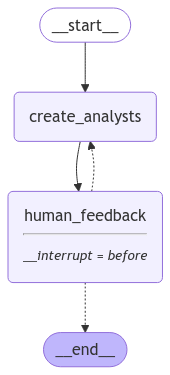

In [ ]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}

2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts:

{human_analyst_feedback}

3. Determine the most interesting themes based upon documents and / or feedback above.

4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

def create_analysts(state: GenerateAnalystsState):

    """ Create analysts """

    topic=state['topic']
    max_analysts=state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback', '')

    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = analyst_instructions.format(topic=topic,
                                                            human_analyst_feedback=human_analyst_feedback,
                                                            max_analysts=max_analysts)

    # Generate question
    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of analysts.")])

    # Write the list of analysis to state
    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateAnalystsState):
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"

    # Otherwise end
    return END

# Add nodes and edges
builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [ ]:
# Input
max_analysts = 4
topic = "The possibility of using Reinforcement learning to detect cyber attacks on traffic lights"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts,}, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Dr. Emily Carter
Affiliation: Cybersecurity Research Institute
Role: Cybersecurity Expert
Description: Dr. Carter focuses on the application of reinforcement learning in cybersecurity, particularly in detecting and mitigating cyber attacks on critical infrastructure like traffic lights. She is concerned with the robustness and reliability of AI models in real-world scenarios and aims to develop systems that can adapt to evolving threats.
--------------------------------------------------
Name: Rajesh Kumar
Affiliation: AI Ethics Council
Role: AI Ethics Specialist
Description: Rajesh is dedicated to exploring the ethical implications of using AI in public safety systems. He is particularly interested in the privacy concerns and potential biases that reinforcement learning models might introduce when deployed in traffic light systems. His goal is to ensure that AI applications are transparent and fair.
--------------------------------------------------
Name: Laura Chen
Affiliation:

In [ ]:
# Get state and look at next node
state = graph.get_state(thread)
state.next

('human_feedback',)

In [ ]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback":
                            "Add in someone from a limitations of Reinforcement learning prespective"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efd9cf8-aa6f-69ad-8002-6aa9738ea329'}}

In [ ]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Dr. Emily Carter
Affiliation: Cybersecurity Research Institute
Role: Cybersecurity Expert
Description: Dr. Carter focuses on the application of reinforcement learning in cybersecurity, particularly in detecting and mitigating cyber attacks on critical infrastructure like traffic lights. She is concerned with the robustness and reliability of AI models in real-world scenarios and aims to develop systems that can adapt to evolving threats.
--------------------------------------------------
Name: Rajesh Kumar
Affiliation: AI Ethics Council
Role: AI Ethics Specialist
Description: Rajesh is dedicated to exploring the ethical implications of using AI in public safety systems. He is particularly interested in the privacy concerns and potential biases that reinforcement learning models might introduce when deployed in traffic light systems. His goal is to ensure that AI applications are transparent and fair.
--------------------------------------------------
Name: Laura Chen
Affiliation:

In [ ]:
# If we are satisfied, then we simply supply no feedback
further_feedack = None
graph.update_state(thread, {"human_analyst_feedback":
                            further_feedack}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efe0ebb-44c3-6afa-8003-c87146974271'}}

In [ ]:
# Continue the graph execution to end
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [ ]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

In [ ]:
final_state.next

()

In [ ]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50)

Name: Dr. Emily Carter
Affiliation: Cybersecurity Research Institute
Role: Cybersecurity Expert
Description: Dr. Carter focuses on the application of reinforcement learning in cybersecurity, particularly in detecting and mitigating cyber attacks on critical infrastructure like traffic lights. She is concerned with the robustness and reliability of AI models in real-world scenarios and aims to develop systems that can adapt to evolving threats.
--------------------------------------------------
Name: Rajesh Kumar
Affiliation: AI Ethics Council
Role: AI Ethics Specialist
Description: Rajesh is dedicated to exploring the ethical implications of using AI in public safety systems. He is particularly interested in the privacy concerns and potential biases that reinforcement learning models might introduce when deployed in traffic light systems. His goal is to ensure that AI applications are transparent and fair.
--------------------------------------------------
Name: Laura Chen
Affiliation:

## Conduct Interview

### Generate Question

The analyst will ask questions to the expert.

In [ ]:
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [ ]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic.

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.

2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}

Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.

When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

def generate_question(state: InterviewState):
    """ Node to generate a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]

    # Generate question
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)

    # Write messages to state
    return {"messages": [question]}

### Generate Answer: Parallelization

The expert will gather information from multiple sources in parallel to answer questions.

For example, we can use:

* Specific web sites e.g., via [`WebBaseLoader`](https://python.langchain.com/v0.2/docs/integrations/document_loaders/web_base/)
* Indexed documents e.g., via [RAG](https://python.langchain.com/v0.2/docs/tutorials/rag/)
* Web search
* Wikipedia search

You can try different web search tools, like [Tavily](https://tavily.com/).

In [ ]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")

TAVILY_API_KEY: ··········


In [ ]:
# Web search tool
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults( max_results=3)

In [ ]:
# Wikipedia search tool
from langchain_community.document_loaders import WikipediaLoader

Now, we create nodes to search the web and wikipedia.

We'll also create a node to answer analyst questions.

Finally, we'll create nodes to save the full interview and to write a summary ("section") of the interview.

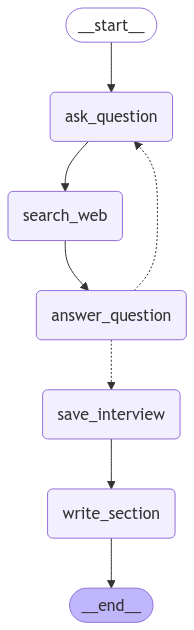

In [ ]:
from langchain_core.messages import get_buffer_string

# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert.

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.

First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")

def search_web(state: InterviewState):

    """ Retrieve docs from web search """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])

    # Search
    search_docs = tavily_search.invoke(search_query.search_query)

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

def search_wikipedia(state: InterviewState):

    """ Retrieve docs from wikipedia """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])

    # Search
    search_docs = WikipediaLoader(query=search_query.search_query,
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}.

You goal is to answer a question posed by the interviewer.

To answer question, use this context:

{context}

When answering questions, follow these guidelines:

1. Use only the information provided in the context.

2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1].

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc

6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list:

[1] assistant/docs/llama3_1.pdf, page 7

And skip the addition of the brackets as well as the Document source preamble in your citation."""

def generate_answer(state: InterviewState):

    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)

    # Name the message as coming from the expert
    answer.name = "expert"

    # Append it to state
    return {"messages": [answer]}

def save_interview(state: InterviewState):

    """ Save interviews """

    # Get messages
    messages = state["messages"]

    # Convert interview to a string
    interview = get_buffer_string(messages)

    # Save to interviews key
    return {"interview": interview}

def route_messages(state: InterviewState,
                   name: str = "expert"):

    """ Route between question and answer """

    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]

    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return "ask_question"

section_writer_instructions = """You are an expert technical writer.

Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents:
- The name of each source document is at the start of the document, with the <Document tag.

2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers

3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst:
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents

6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/

8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]

    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")])

    # Append it to state
    return {"sections": [section.content]}

# Add nodes and edges
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Interview
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [ ]:
# Pick one analyst
analysts[2]

Analyst(affiliation='Urban Traffic Management Authority', name='Laura Chen', role='Traffic Systems Engineer', description='Laura is focused on the integration of AI technologies into existing traffic management systems. She is interested in how reinforcement learning can optimize traffic flow while simultaneously enhancing security against cyber threats. Her main concern is ensuring that these systems are scalable and maintainable in urban environments.')

Here, we run the interview passing an index of the llama3.1 paper, which is related to our topic.

In [ ]:
from IPython.display import Markdown

messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
thread = {"configurable": {"thread_id": "1"}}
interview = interview_graph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns": 2}, thread)
Markdown(interview['sections'][0])

## Reinforcement Learning in Cybersecurity: Enhancing Detection and Mitigation of Cyber Attacks

### Summary

The rapid advancement of online platforms has heightened the risk of cyber attacks, particularly on critical infrastructure such as traffic lights. As these threats evolve, the need for robust and adaptive cybersecurity measures becomes increasingly urgent. Reinforcement learning (RL), a subset of machine learning focused on sequential decision-making, offers promising solutions for enhancing intrusion detection systems (IDS) and mitigating cyber threats. This report explores the application of RL in cybersecurity, emphasizing its potential to improve the robustness and reliability of AI models in real-world scenarios.

Reinforcement learning techniques, including Markov algorithms, are being developed to counteract evolving cyber threats [1]. These algorithms enable systems to learn and adapt incrementally, making them well-suited for dynamic environments where complete knowledge or control is not feasible [3]. A novel application of RL is in the detection of cyber attacks on Internet of Things (IoT) devices, addressing a significant gap in the literature [2]. By leveraging IoT telemetry data, RL algorithms can enhance the detection of anomalies, which often serve as the only indicators of cyber attacks in certain instances.

Anomaly detection through RL is further exemplified in network intrusion scenarios, such as Bot attacks [4]. The integration of deep reinforcement learning (DRL) and active learning has led to the development of new algorithms, like RLAD, which efficiently learn and adapt to anomalies in real-world time series data [5]. These models continuously refine their detection capabilities based on experience, without assuming a predefined mechanism for the observation sequence.

Moreover, the use of Python and its ecosystem of libraries facilitates the application of machine learning techniques, including time-series analysis, to detect anomalies in network traffic [6]. This approach involves visualizing network data, identifying traffic spikes, and employing deep learning models like Long Short-Term Memory (LSTM) networks and Gated Recurrent Units (GRU) to detect anomalies in sequential data.

In summary, the application of reinforcement learning in cybersecurity represents a significant advancement in the detection and mitigation of cyber attacks. By enabling systems to adapt to evolving threats, RL enhances the robustness and reliability of AI models, making them indispensable tools in protecting critical infrastructure.

### Sources
[1] https://ieeexplore.ieee.org/document/10730493  
[2] https://www.sciencedirect.com/science/article/pii/S0167404824000877  
[3] https://link.springer.com/chapter/10.1007/978-3-030-97532-6_4  
[4] https://zighra.com/blogs/anomaly-detection-through-reinforcement-learning/  
[5] https://arxiv.org/abs/2104.00543  
[6] https://medium.com/@pythonshield/anomaly-detection-in-network-traffic-using-python-e179682fdd05  

### Parallelze interviews: Map-Reduce

We parallelize the interviews via the `Send()` API, a map step.

We combine them into the report body in a reduce step.

### Finalize

We add a final step to write an intro and conclusion to the final report.

In [ ]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict

class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report

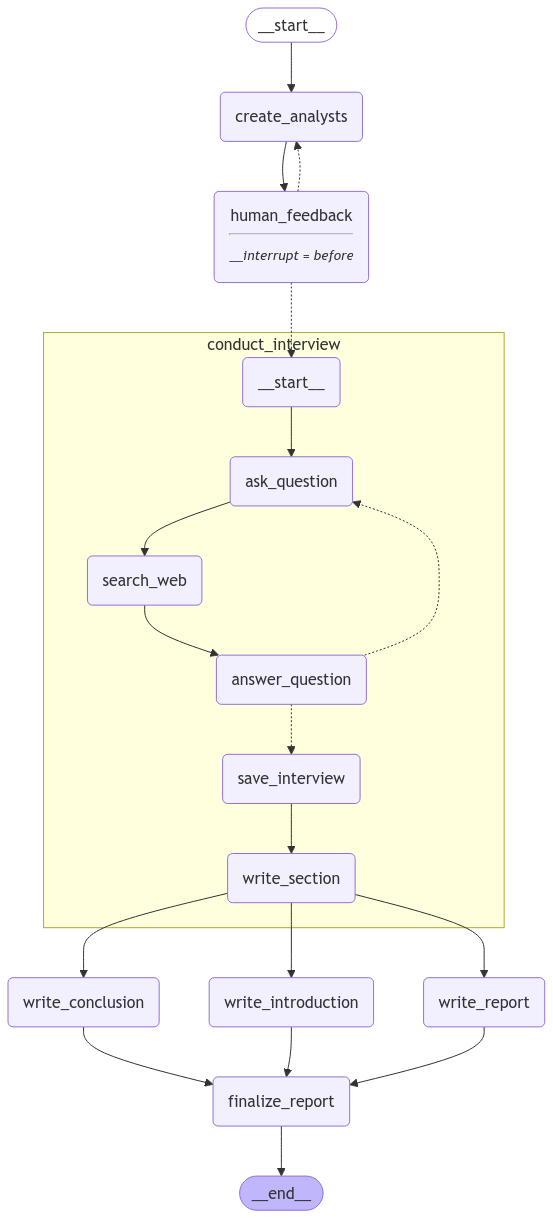

In [ ]:
from langgraph.constants import Send

def initiate_all_interviews(state: ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"

    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                           "messages": [HumanMessage(
                                               content=f"So you said you were writing an article on {topic}?"
                                           )
                                                       ]}) for analyst in state["analysts"]]

report_writer_instructions = """You are a technical writer creating a report on this overall topic:

{topic}

You have a team of analysts. Each analyst has done two things:

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task:

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos.
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:

1. Use markdown formatting.
2. Include no pre-amble for the report.
3. Use no sub-heading.
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from:

{context}"""

def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")])
    return {"content": report.content}

intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting.

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header.

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # Summarize the sections into a final report

    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")])
    return {"introduction": intro.content}

def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # Summarize the sections into a final report

    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")])
    return {"conclusion": conclusion.content}

def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

# Add nodes and edges
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

Let's ask an open-ended question about LangGraph.

In [ ]:
# Inputs
max_analysts = 3
topic = "Reinforcement learning in Network defense attacks"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,
                           "max_analysts":max_analysts},
                          thread,
                          stream_mode="values"):

    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Dr. Emily Carter
Affiliation: Cybersecurity Research Institute
Role: Reinforcement Learning Specialist
Description: Dr. Carter focuses on the application of reinforcement learning algorithms to enhance network defense mechanisms. Her primary concern is optimizing these algorithms to adapt to evolving cyber threats in real-time. She is motivated by the potential of AI to revolutionize cybersecurity by making systems more autonomous and resilient against sophisticated attacks.
--------------------------------------------------
Name: Mr. John Smith
Affiliation: National Cyber Defense Agency
Role: Network Security Analyst
Description: Mr. Smith is dedicated to understanding the practical implications of reinforcement learning in network defense. His focus is on evaluating the effectiveness of these AI-driven strategies in real-world scenarios and ensuring they align with existing security protocols. He is particularly concerned with the integration challenges and the potential for AI

In [ ]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback":
                                "Add in the prespective of someone who understands the limitations of Reinforement Learning and remove Gen AI and langchain specialist as it is not needed"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efe0fa4-3ea4-614e-8002-c59be2673b7c'}}

In [ ]:
# Check
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Dr. Emily Carter
Affiliation: Cybersecurity Research Institute
Role: Reinforcement Learning Specialist
Description: Dr. Carter focuses on the application of reinforcement learning algorithms to enhance network defense mechanisms. Her primary concern is optimizing these algorithms to adapt to evolving cyber threats in real-time. She is motivated by the potential of AI to revolutionize cybersecurity by making systems more autonomous and resilient against sophisticated attacks.
--------------------------------------------------
Name: Mr. John Smith
Affiliation: National Cyber Defense Agency
Role: Network Security Analyst
Description: Mr. Smith is dedicated to understanding the practical implications of reinforcement learning in network defense. His focus is on evaluating the effectiveness of these AI-driven strategies in real-world scenarios and ensuring they align with existing security protocols. He is particularly concerned with the integration challenges and the potential for AI

In [ ]:
# Confirm we are happy
graph.update_state(thread, {"human_analyst_feedback":
                            None}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efe0fa4-ab53-6524-8004-327080a175b5'}}

In [ ]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
conduct_interview
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
write_conclusion
--Node--
write_introduction
--Node--
write_report
--Node--
finalize_report


In [ ]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# Reinforcement Learning: Revolutionizing Network Defense Strategies

## Introduction

In the ever-evolving landscape of cybersecurity, reinforcement learning (RL) is emerging as a game-changer for network defense strategies. As cyber threats grow in complexity, traditional defense mechanisms struggle to keep up. This report explores how RL, particularly multi-agent reinforcement learning (MARL), is transforming automated defense systems by enabling real-time prediction and response to network attacks. We delve into innovative defense mechanisms, adversarial training, and autonomous cyber defense, highlighting their potential to enhance security resilience. Additionally, we address the ethical and policy challenges of deploying RL in cybersecurity, emphasizing the need for comprehensive guidelines to ensure responsible use. Finally, we examine the challenges of applying RL in real-world scenarios and propose strategies to overcome these hurdles, paving the way for more effective cybersecurity solutions.

---



Reinforcement learning (RL) is increasingly recognized as a transformative force in the field of network defense, offering innovative solutions to counteract sophisticated cyber threats. As traditional defense mechanisms struggle to keep pace with the evolving landscape of cybersecurity, RL's ability to adapt and learn from dynamic environments presents a promising avenue for enhancing automated defense systems. Recent advancements, particularly in multi-agent reinforcement learning (MARL), have paved the way for autonomous cyber defense systems capable of predicting and responding to network attacks in real-time. These systems are notable for their ability to autonomously adapt to evolving threats, a crucial capability in the face of complex cyber-attacks [1][2].

The integration of RL into intrusion detection systems (IDS) through techniques like Markov algorithms exemplifies the innovative defense mechanisms being developed. These algorithms enable systems to learn from past attacks, thereby improving detection capabilities over time [1]. Additionally, the use of deep reinforcement learning (DRL) in simulating adversarial attacks has demonstrated the potential of RL in training robust defense mechanisms that can withstand real-world cyber threats [2]. A proof of concept for RL-driven autonomous defense has shown that multi-agent approaches outperform single-agent systems, highlighting their potential for real-world application [3][4]. Furthermore, the development of self-adaptive security systems using RL frameworks marks a significant step forward, reducing the need for human intervention and enhancing organizational security postures [5].

However, the deployment of RL in cybersecurity is not without its challenges, particularly concerning ethical and policy implications. The autonomous decision-making capabilities of RL systems raise significant concerns, including the potential for unintended consequences and ethical dilemmas. The absence of human oversight in critical decision-making processes necessitates comprehensive guidelines and regulations to govern the use of RL in cybersecurity. Transparency, accountability, and alignment with societal values are emphasized as foundational principles for these guidelines [1][2]. Regulatory frameworks like GDPR and CCPA, along with the Federal Trade Commission's (FTC) emphasis on transparency and accountability, guide businesses in aligning AI-driven cybersecurity solutions with ethical standards and societal expectations [3][4].

Moreover, the application of RL in real-world cybersecurity scenarios presents several technical challenges. The need for vast amounts of data to train models effectively is a significant barrier, as traditional data-based methods fall short in addressing the dynamic nature of cyber threats [1][2]. The risk of overfitting, where models become too tailored to training data and fail to generalize to new scenarios, is another critical issue. This concern necessitates careful model design and training strategies to ensure RL systems can perform effectively in real-world environments [3][4]. Additionally, simulating realistic attack scenarios for training RL models is inherently challenging, as the dynamic interaction between attackers and defenders is difficult to replicate in controlled environments [2].

In conclusion, while RL offers significant potential to enhance network defense systems, it is imperative to address both the ethical and technical challenges associated with its deployment. By leveraging the adaptive capabilities of RL and ensuring responsible use through clear guidelines and regulations, cybersecurity systems can become more resilient, efficient, and effective in mitigating sophisticated cyber threats.


---

## Conclusion

Reinforcement learning (RL) is reshaping network defense strategies by offering adaptive and autonomous solutions to counter sophisticated cyber threats. This report explored the integration of RL into innovative defense mechanisms, highlighting its role in enhancing intrusion detection systems and developing robust adversarial training methods. The potential of RL-driven autonomous cyber defense systems was demonstrated, showcasing their ability to generalize across unseen network topologies. However, the deployment of RL in cybersecurity also presents ethical and policy challenges, necessitating comprehensive guidelines to ensure responsible use. Addressing these challenges, alongside overcoming data and overfitting issues, is crucial for realizing RL's full potential in cybersecurity.

## Sources
[1] https://ieeexplore.ieee.org/document/10730493  
[2] https://dl.acm.org/doi/abs/10.1145/3660853.3660930  
[3] https://arxiv.org/abs/2410.17351  
[4] https://i.blackhat.com/BH-US-24/Presentations/US-24-MilesFarmer-ReinforcementLearningForAutonomousResilientCyberDefence-wp.pdf  
[5] https://ejaet.com/PDF/10-10/EJAET-10-10-102-105.pdf  
[6] https://ijesrr.org/publication/89/4.+sep+2022+ijesrr.pdf  
[7] https://www.forbes.com/councils/forbestechcouncil/2024/11/25/ai-in-cybersecurity-understanding-the-new-regulatory-framework-and-what-it-means-for-businesses/  
[8] https://www.ftc.gov/system/files/ftc_gov/pdf/FTC-AI-Use-Policy.pdf  
[9] https://www.mdpi.com/1999-4893/15/4/134  
[10] https://www.researchgate.net/publication/360041760_Research_and_Challenges_of_Reinforcement_Learning_in_Cyber_Defense_Decision-Making_for_Intranet_Security  
[11] https://ai.stackexchange.com/questions/20127/how-can-i-handle-overfitting-in-reinforcement-learning-problems  
[12] https://arxiv.org/abs/1804.06893